# Rainbow

A notebook exploring rainbows using water-droplet geometry.

If you are interested in the punchline without all the intermediary steps: Scroll to the bottom, last section. I don't provide this in the summary to preserve a semblance of drama... do rainbows exist???


## Part 0 Assumptions

We build a conceptual picture of a rainbow using simple ideas chained together. The first set of ideas are expressed in a very minimal way. Then I re-state them in a more elaborate "you are there" fashion. The rest of the notebook puts the ideas into practice as Python code; with plots and figures. Let's see if there is a convincing case for rainbows to exist. 

#### Simple statement of assumptions

* Light of all colors arrives from the sun, a distant point source, and scatters from a cloud of droplets in the air.
* Light particles scatter through spherical water droplets based on the normal to the droplet surface at the point of arrival according to Snell's law. 
* Some light follows a Snell refraction followed by a reflection followed by another refraction: That's what we wish to map.
* Does a uniform distribution of photons impinging on a distribution of droplets produce the sensation of a coherent rainbow in the eye of a person looking toward the droplets and away from the sun? Of course it does; but do these assumptions 'produce' that result?

#### Detailed statement of assumptions

* Rainbows are formed from the backscatter of light incident on water droplets suspended in air. The water droplets may be falling fast (like rain) but more typically they are very small -- like mist -- and fall slowly. 
* Where is the light coming from? Light arrives from the sun at a low angle, as in 'over your shoulder'. You look directly away from the sun. The light particles (photons) coming over your shoulder hit water droplets suspended in the air before you. These might be close, as from a garden hose set on 'spray', or they might be far, as in a distant rain cloud. 
* The light reflects from or scatters from the droplets of water and some of this scattered light enters your eye. The pattern of reflected light that you perceive is interpreted by you as arcs of concentric color, a rainbow. Red is on the inside of the bow, blue on the outside.
* Someone standing next to you also sees a rainbow. Is it in the same place?

That's the basic observation. Now I will describe the first model for scattering of light by water droplets. It relies on the idea of a normal to a surface so let me say first: A curved surface like a water droplet that is examined at a very small point can be seen as locally flat. The flat plane is called the tangent plane and a spike sticking up out of this plane at a right angle to it is called the normal direction. In optics when light encounters a boundary such as air-to-water the interaction is described in terms of this surface normal. Notice that for a sphere the tangent plane is perpendicular to a line from the center of the sphere to the surface. For the sphere the surface normal at a point is coincident with a radial line from the center. 

* We assume water droplets are small so surface tension pulls them into a spherical shape. They are suspended in the air and move slowly enough that we consider them to be holding still.
* Light enters each water droplet in a spatially even distribution of parallel rays as if from an infinitely distant point source. (We do not consider that the sun has width, i.e. subtends a solid angle. This is one of several details in the assumptions where we could come back and say 'wait a second... what about the width of the sun?'
* Light entering the water droplet obeys Snell's law, traveling in a plane defined by two vectors: The incident velocity vector and the vector normal to the sphere at the point of incidence. This plane passes through the center of the droplet sphere. 
    * Snell's law gives us a result that each photon travels in a circular disc that bisects the water droplet. This simplifies our problem because we can work in two dimensions, in an arbitrary plane of bisection; and then after that we can extend the results to the fact that these planes can be oriented at any angle around the line from the sun to the droplet. 
* This is a relative distribution problem: Given a bunch of sunlight where do the light particles tend to go? The water drops are distributed in a sheet at random and act to scatter only the light that hits them; so they are independent of one another.  Further the photons are very small and taken to behave like point-particles. Consequently the radius of the droplets is immaterial and is taken to be 1. The number of photons is taken to be very large. The code below does not need to try and use actual photon counts or droplet sizes. 'Lots of photons' and 'radius = 1' will do. 
* The idea is to consider the scattering of light for a single droplet and then eventually to explore the effect of many such scatterers.

Finally (whew this is taking a lot of words!) we want to consider the scattering path of the photon in detail. That's what everything depends on. 

* While many incident light particles scatter off the droplet, and while many more will pass through the back of the droplet, we are concerned only with backscatter and therefore only the following trajectory: 
    * The incident light particle (photon) enters the droplet
        * Its path bends on entry per Snell's law
    * The photon reflects off the back of the droplet thereby staying inside the droplet
        * Its path obeys angle of incidence = angle of reflection off the plane tangent to the droplet surface
    * The photon impinges a second time on the surface of the droplet, this time passing through it
        * Undergoing another path bend per Snell's law
* We make the problem two dimensional as noted, considering one particular plane bisecting the water droplet sphere; so we are working with the unit circle. 
* We take a uniform distribution of incident particles arriving at the first quadrant of that unit circle from y = 0 (aligned with the center of the droplet) to y = 1 grazing the top of the droplet. The particles from y = 0 to y = -1 are just a reflection so let's not worry about them. 
* Each particle is initially traveling with no y-component to its velocity: It simply comes in from the far right on a path exactly parallel to the x-axis.

Finally when all is said and done we may ask: If we throw a million photons at the water droplet each separated by one millionth in the y direction: At what angle will they be ejected by the droplet? Do they go all over the place or is there perhaps a preferred direction of scattering? If the latter then the water droplet would be acting as a light-focusing mechanism; which sort of stands to reason because the water droplet is curved a bit like a lens.

## Part 1 Droplet Scattering

In [1]:
# make plots exist inline (not pop-out) and get the numpy and pyplot libraries in place. And make pi easier to write.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

In [2]:
# This dispersion relation is a simple linear interpolation between red and violet values; approximately correct
def indexOfRefractionForWater(wavelength):
    if (wavelength < 400.0): return
    if (wavelength > 700.0): return
    ind400 = 1.339
    ind700 = 1.331
    deltaind = ind700 - ind400
    deltawavefraction = (wavelength - 400.0)/300.0
    return (deltaind * deltawavefraction) + ind400


In [3]:
# generic binning to histogram
def getbin(value, lo, hi, bins):
    if (value <= lo): return 0
    if (theta >= hi): return bins-1
    bin = int((value-lo)*(bins/(hi - lo)))
    if (bin >= 0 and bin < bins):
        return bin

In [4]:
# Snell's law generalization to incident and transmission media
def snell(thetaInc, indexInc, indexTrans):
    return np.arcsin((indexInc/indexTrans)*np.sin(thetaInc))

In [5]:
# you just know this already exists
def rtd(theta): return theta*180.0/pi

In [6]:
# you just know this already exists
def dtr(theta): return theta*pi/180.0

In [7]:
def scatter(y, wavelength, iorAir, iorWater):
    alpha = np.arcsin(y)          # alpha is the angle of incidence
    beta = snell(alpha, iorAir, iorWater)   
    return 4.*beta - 2.*alpha

In [8]:
def scatterWithFresnel(y, wavelength):
    iorAir = 1.00029
    iorWater = indexOfRefractionForWater(wavelength)
    alpha = np.arcsin(y)          # alpha is the angle of incidence
    beta = snell(alpha, iorAir, iorWater)   
    T1 = 1.0 - RCoefficient(alpha, iorAir, iorWater)
    R1 = RCoefficient(beta, iorWater, iorAir)
    T2 = 1.0 - R1 # Since beta is found at both Q and R
    return T1, R1, T2, 4.*beta - 2.*alpha

In [9]:
def RCoefficient(theta, n1, n2):
    sineTerm = (n1/n2)*np.sin(theta)
    radArg = 1 - sineTerm*sineTerm
    radical = np.sqrt(radArg)
    RsNum = n1*np.cos(theta) - n2*radical
    RsDenom = n1*np.cos(theta) + n2*radical
    RpNum = n1*radical - n2*np.cos(theta)
    RpDenom = n1*radical + n2*np.cos(theta)
    Rs = (RsNum * RsNum) / (RsDenom * RsDenom)
    Rp = (RpNum * RpNum) / (RpDenom * RpDenom)
    return (Rs+Rp)/2.0

In [10]:
# This cell is configuration steps prior to the next cell running

# To keep track of where the light goes (scattering angle) we create a list of histograms cut into 0.001-radian bins
#   Each histogram will track a particular color as the incoming photons cycle from y = 0 to y = 1
epsilon = 0.001
domainLo = -pi/2.
domainHi = pi/2.
domain = np.arange(domainLo, domainHi, epsilon)
domainBins = domain.shape[0]

domainDeg = domain * 180.0 / pi
print type(domain)

cWaves = [400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0]    # list of color-associated wavelengths of light (nm)
cLabels = ['violet', 'b','cyan','g', 'y', 'orange', 'r']      # color labels for the light
nC = len(cWaves)    # how many colors to consider
# nC = 1     # uncomment this to test code against 'just violet' (faster)

histogram = []          
for i in range(nC):
    histogram.append(np.zeros(domainBins))  # list of histograms accumulated by wavelength/color
print len(histogram)

yIncident = []     # an array of incident y-values (offsets from the droplet-sun line)
alphaDeg = []      # incoming incidence relative to normal
thetaDeg = []      # scatter angle

for i in range(nC):
    thetaDeg.append([])  # a List of outputs accumulated by wavelength

<type 'numpy.ndarray'>
7


In [11]:
# This cell fires one million photons at the droplet nC (number-of-colors) times and tracks where they come out

maxTheta = -2.*pi
yOfMaxTheta = 0.0
firstY = 0.0
lastY = 1.0
intervalY = 0.000001

# preceding the color loop we bookkeep information that applies to all colors across the y-coordinate scan
for yP in np.arange(firstY, lastY, intervalY):
    # alpha is local incidence, common to all colors
    yIncident.append(yP)
    alpha = np.arcsin(yP)          # alpha is the angle of incidence
    alphaDeg.append(rtd(alpha))    # include 'degrees' for familiarity

# loop index i over all colors of interest ('ROYGBIV')
for i in range(nC):

    wavelength = cWaves[i]

    # index of refraction of water depends on wavelength
    # this prismatic effect is called 'dispersion of light'
    iorWater = indexOfRefractionForWater(wavelength)

    # index of refraction for air is taken as wavelength-independent
    iorAir = 1.00029

    x = 1000.0            # technically should be about 93 million miles (but we don't use this value)

    for yP in np.arange(firstY, lastY, intervalY):

        # Per the diagram:
        #   (x, y) is a point of origin off towards the sun
        #   (xP, yP) is where the incident photon strikes the droplet at point P
        #   C is the center of the droplet (the origin) in this coordinate system
        #   U (for _Unity_) is the point at (1, 0), a convenient reference point
        #   Q is the point of photon reflection at the back edge of the droplet
        #   R is the point where the photon emerges from the droplet back into the air       
        # P = (xP, yP)
        # Not used: xP = np.sqrt(1.0-yP*yP) # positive square root puts P in the first quadrant


        # beta is the internal refracted angle relative to the unit normal at P
        # beta = snell(alpha, iorAir, iorWater)
        
        # theta = 4.*beta - 2.*alpha
        # Notice we do not use 'scatterWithFresnel' so the result is unweighted: 1 photon
        theta = scatter(yP, wavelength, iorAir, iorWater)
        
        # The subsequent code here is commented out. It concerns 'following the photon' through 
        # the droplet which is revisited in subsequent sections when we consider attenuation.
        # 
        # WARNING: The following code has not been tested; just written up in comments. (kilroy)
        #
        # beta is the refracted angle: Bending in towards the normal line at point P
        # the deflected photon next strikes the back wall of the droplet at point Q
        # angleQCP is from triangle QCP being isosceles
        # angleQCP = pi - 2*beta
        #
        # angleQCU is relative to the +x axis, the line from droplet to sun
        # angleQCU = angleQCP + alpha
        #
        # Q = (xQ, yQ)
        # xQ = np.cos(angleQCU)
        # yQ = np.sin(angleQCU)
        #
        # The light reflects at Q using angle(incidence) = angle(reflection)
        # It will next strike the surface of the droplet at point R
        # angleQCR = angleQCP             # again using isosceles arguments
        #
        # angleRCU measures positive from RC clockwise to UC
        # angleRCU = angleQCR + angleQCU
        #
        # R = (xR, yR)
        # xR = np.cos(angleRCU)
        # yR = np.sin(angleRCU)
        # 
        # angleUCR is positive measured from UC clockwise to CR 
        # This angle is the angle of the normal at R
        # angleUCR = 2*pi - angleRCU
        #
        # The rays will emerge at R in some direction to intersect an outer circle of radius 'large'. 
        # S = the emergent ray's point of intersection with the outer circle = (xS, yS)
        # 
        # gamma is the refraction angle at R
        # gamma = snell(beta, iorWater, iorAir)
        #
        # theta is the scatter angle from the droplet, calculated above. It can be calculated directly
        #   here by subtracting gamma from angleUCR. The result will be positive or zero.
        # theta_version2 = angleUCR - gamma
        #
        # theta_version2 will differ from theta by a very small amount due to floating point precision

        if theta > maxTheta:
            maxTheta = theta
            yOfMaxTheta = yP
            
        thetaDeg[i].append(rtd(theta))
        binNumber = getbin(theta, domainLo, domainHi, domainBins)

        # I include Transmission and Reflection and Transmission coefficients to anticipate calculating
        #   them more carefully down below in this notebook.
    
        if binNumber >= 0 and binNumber < domainBins: histogram[i][binNumber] += 1

print len(thetaDeg[0])
print len(yIncident)
print 'Carry on, Sergeant Major!'

1000000
1000000
Carry on, Sergeant Major!


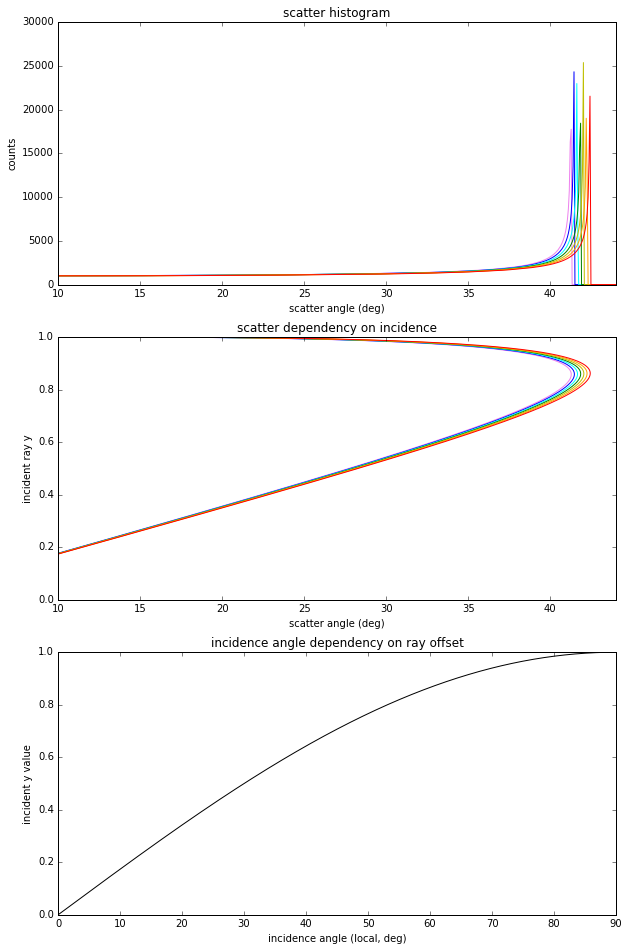

In [12]:
# This cell creates a stack of three plots: histogram of scatter angles, scatter as function of incidence, and the range of incidence angles.

# plt.subplots returns a tuple: A general-context figure and a list of sub-plots assigned to axes
fig, axes = plt.subplots(3, figsize=(10,16))
axisHistogram = axes[0]    # I break the axes list apart into more identifiable names
axisScatter   = axes[1]
axisIncidence = axes[2]

for i in range(nC):
    axisHistogram.plot(domainDeg, histogram[i], cLabels[i])
    axisScatter.plot(thetaDeg[i], yIncident, cLabels[i])

axisIncidence.plot(alphaDeg, yIncident, 'k')

axisHistogram.set(xlim=(10.0, 44.0))
axisHistogram.set(xlabel='scatter angle (deg)', ylabel = 'counts', title='scatter histogram')

axisScatter.set(xlim=(10.0, 44.0))
axisScatter.set(ylabel='incident ray y', xlabel = 'scatter angle (deg)', title='scatter dependency on incidence')

axisIncidence.set(xlim=(0.0, 90.0),ylim=(0.0,1.0))
axisIncidence.set(ylabel='incident y value', xlabel = 'incidence angle (local, deg)', title='incidence angle dependency on ray offset')

__Caption__ The top figure shows that a disproportionate number of photons emerge at an angle of 41 to 42 degrees or so. The water droplet focuses the light into these angles which vary a bit with wavelength. The center figure shows that these spikes are due to a range of incident y-values from about y = .75 to y = .9. That range gives the concentration shown by the spikes in the first figure. The third figure shows that the y value of the incident light maps into incidence angle fairly linearly for y on [0.0, 0.6] and then starts to curve for larger values of y, reaching incidence angles of 70 degrees or higher for y on [0.9, 1.0]. This information is used in a later section that accounts for all the incident light, not just the photons that follow our recipe of transmit-reflect-transmit.  

In [13]:
redIndex = nC-1
violetIndex = 0
maxRedIndex = np.where(histogram[redIndex] == histogram[redIndex].max())[0][0]
maxVioletIndex = np.where(histogram[violetIndex] == histogram[violetIndex].max())[0][0]

redMaxAngleDegrees = rtd(domain[maxRedIndex])
violetMaxAngleDegrees = rtd(domain[maxVioletIndex])

redMAD2 = round(redMaxAngleDegrees, 2)
violetMAD2 = round(violetMaxAngleDegrees, 2)
print 'red max histogram angle:', redMAD2, 'deg'
print 'violet max histogram angle:', violetMAD2, 'deg'
print 'Wikipedia rainbow is 42.00 - 40.89 =', 42.00 - 40.89, 'degrees wide'
print 'This rainbow is', redMAD2, '-', violetMAD2, '=', round(redMaxAngleDegrees - violetMaxAngleDegrees, 2), 'degrees wide'

# 40.89 to 42 (red) is 1.11 degrees (Wikipedia article on rainbows)
# My rainbow is 1.146 degrees wide


red max histogram angle: 42.41 deg
violet max histogram angle: 41.26 deg
Wikipedia rainbow is 42.00 - 40.89 = 1.11 degrees wide
This rainbow is 42.41 - 41.26 = 1.15 degrees wide


## Part 2. Photon trajectory tracer

Now that we have shown an emphasized scattering direction... which is just the starting point of a convincing argument unless you like jumping to conclusions... it is time to look at what happens to the individual particles as they are incident on the water droplet. 

For wavelength 400 nm the max eject angle is 41.19 at incidence y = 0.84
For wavelength 700 nm the max eject angle is 42.3 at incidence y = 0.84


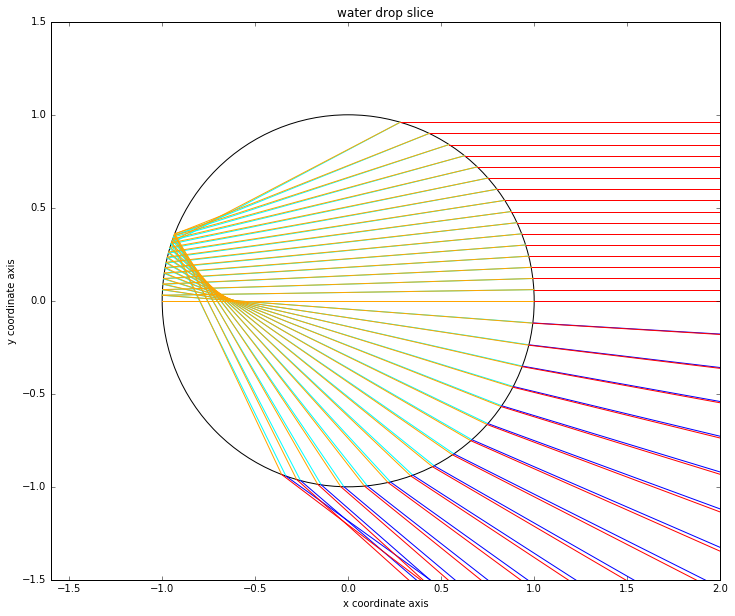

In [21]:
# This cell narrates some more of "what's happening" in graphics rendering and shows a set of incident photon
#   paths through a 2D slice of a water droplet.

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12,10))

# now we say that 'fig' is the overall canvas
# ax is the (list of) axes
# after this we leave fig alone and just use ax
#
# The heirarchy: figure contains a bunch of axes (subplots) and an axis contains a bunch of artists
#
# How can we make the figure larger? Here are some constructions where 'plt' is 'matplotlib.pyplot'.
# fig.set_figure()
# plt.figure(figsize=(12,12))
# fig = plt.figure(figsize=(12,10))

# a patch is a filled shape
# from matplotlib import patches
# patches.<tab> shows you them
# This circle patch is not filled
ax.add_patch(plt.Circle((0, 0), 1, color = 'k', fill=False))

# Drawing a (not very) distant circle as the proxy for many observing eyes.
# That is, I needed a definite locus of points to act as endpoints for the ejected
#   photons; so I chose a circle of radius 2, just twice that of the unit circle 
#   used for the droplet. 
radiusCircleAtInf = 2.0
# ax.add_patch(plt.Circle((0, 0), radiusCircleAtInf, color = 'k', fill=False))

# unity aspect ratio
ax.axis('equal')

# How To note...
# ax.set_xlim(-7, 7)
# ax.set_ylim(-7, 7)

ax.set(xlim=(-1.1, 1.5), ylim=(-1.5,1.5))
ax.set(xlabel='x coordinate axis', ylabel = 'y coordinate axis', title='water drop slice')

maxEject = -pi
maxIncidentY = 0.0

colorScheme = 0
colorSelect = [
    [['blue','cyan','cyan','blue'],['red','orange','orange','red']], 
    [['blue','cyan','green','black'],['none','none','none','none']], 
    [['none','none','none','none'],['red','orange','orange','red']]  
    ]

for w in range(2):

    wavelength = 400 + 300*w

    # indices of refraction
    iorWater = indexOfRefractionForWater(wavelength)
    iorAir = indAir = 1.00029

    yInterval = 0.06

    # The commented out version separates red and blue incident rays visually
    # for y0 in np.arange(w*yInterval/2., 1.0, yInterval):
    for y0 in np.arange(0.0, 1.0, yInterval):
    
        # (x0, y0) is the point off at + infinity where one of the parallel rays comes in from
        x0 = 3.0

        # (x, y) is the point at which a ray intersects the surface of the droplet (radius = 1)
        # Call this point P
        # Call the center of the circle/sphere point C
        # Call (1, 0) the point U (for Unit). It is a convenient reference point.
        y = y0
        x  = np.sqrt(1.0-y*y)

        # here is our incident ray
        ax.plot([x0, x], [y, y], color=colorSelect[colorScheme][w][0])

        # Take out the radial lines to reduce clutter
        # ax.plot([0.0, x], [0.0, y], color='g')

        # incidenceAngle1 is measured relative to the circle (sphere) normal at (x, y)
        incidenceAngle1 = np.arctan2(y, x)

        # angleWater is the refracted angle: Bending in towards the normal line
        angleWater = snell(incidenceAngle1, iorAir, iorWater)
    
        # the ray will deflect and strike the far wall of the droplet at point Q
        # internal1 = angle QCP (a positive value; from isoscelesiness)
        internal1 = pi - 2*angleWater

        # internalTotal1 = angle QCU
        internalTotal1 = internal1 + incidenceAngle1

        # Q = (x2, y2)
        x2 = np.cos(internalTotal1)
        y2 = np.sin(internalTotal1)

        # Now draw the first leg of the journey inside the water drop
        ax.plot([x2, x], [y2, y], color=colorSelect[colorScheme][w][1])

        # The light reflects at Q using angle(incidence) = angle(reflection)
        # It will strike the surface of the droplet at point R
        # internal2 = angle QCR
        internal2 = pi - 2*angleWater              # the same as internal1!

        # internalTotal2 = RCU measured as positive from R clockwise to U
        internalTotal2 = internalTotal1 + internal2

        # R = (x3, y3)
        x3 = np.cos(internalTotal2)
        y3 = np.sin(internalTotal2)

        # Draw the second part of the path through the drop
        ax.plot([x2, x3], [y2, y3], color=colorSelect[colorScheme][w][2])
        # print rtd(angleWater)

        # externalTotal is the angle UCR measured from U clockwise to R 
        # It is 'external' because this angle is the angle of the normal at R
        externalTotal = 2*pi - internalTotal2

        # The rays will escape in some direction and intersect an outer circle of radius 'large'. 
        # S = the emergent ray's point of intersection with the outer circle = (x4, y4)

        # incidenceAngle2 = the incidence angle at R relative to the normal
        incidenceAngle2 = (pi - internal2)/2.

        # external = the transmission angle at R relative to the normal
        external = snell(incidenceAngle2, iorWater, iorAir)

        # ejectAngle is the angle at which the ray is ejected from the drop
        #   measured relative to the +x-axis direction. It will tend to be
        #   sign-changed in subsequent calculations; that is under the conditions
        #   established here it is technically negative. Soi sage.
        ejectAngle = externalTotal - external

        if ejectAngle > maxEject:
            maxEject = ejectAngle
            maxIncidentY = y0

        # Now we have triangle CRS from the center to the eject point R to the intersection
        #   of the ejected ray with Circle(radius 2) at point S. We need the coordinates of 
        #   S now. We could use a very large circle centered on R as an approximation for a
        #   very large circle centered at the origin C...
        radiusLarge = 1000.0
        x4 = radiusLarge * np.cos(-ejectAngle)
        y4 = radiusLarge * np.sin(-ejectAngle)
        ax.plot([x3, x4], [y3, y4], color=colorSelect[colorScheme][w][3])

    print 'For wavelength', wavelength, 'nm the max eject angle is',\
        round(rtd(maxEject),2), 'at incidence y =', maxIncidentY


__Caption__ This figure shows light particle paths that follow our refract-reflect-refract recipe. Recall that photons with a y value close to 1.0 do not contribute to the 'spike' (Figure 1, top and middle). Since the view here emphasizes the photon path inside the water droplet it misses the big picture of 'where does the light tend to go?' For that view we produce a new figure where the droplet is scaled down to _dot_ size.

## Part 3. Droplet from a distance

Let's draw the same diagram as above with two changes. First we'll make the scale of the diagram much larger so that the drop diminishes to a point scatterer. Second let's figure out a way of indicating the histogram: Where most of the light goes in relation to other directions.



## Part 4. Fresnel has a say

There is an important extension of the basic geometric path given above: The photon/boundary interaction is probabilistic: There are probabilities for the photon's future for transmission, reflection, scattering and absorption; and even this is a simplification. Here I constrain the discussion to _'either reflect or transmit'_ to  explore the problem of rainbows in a bit more depth:

* Does the reflect / transmit probability vary with angle; which could change our intensity distribution that appeared very conveniently up above.
* Does the reflect / transmit probability give a story for secondary, tertiary etc rainbows?

The rule for transmit-versus-reflect is expounded (to a degree) by Wikipedia of course, under the topic of Fresnel equations: https://en.wikipedia.org/wiki/Fresnel_equations.

Interestingly for a particular wavelength we could use red and blue lasers together with a suitable attenuated light sensor to measure the reflection as a function of angle. This would be an experiment suited to students in the 11 to 18 years age range but I would recommend incorporating it into other work so as to avoid the _geek out problem_: If an enthusiast like me goes to a lot of trouble to show something that is already well understood it is not clear that the feeling of satisfaction will be shared by others who are less enthusiastic... But there is plenty of material just on this Notebook page to arrive at 'lots more'.

In [ ]:
from IPython.display import Image 
fresnelEquations = Image(filename='../images/Fresnel_equations_Wikipedia.png')
fresnelEquations

In [ ]:
epsilon = 0.001
domain = np.arange(-pi/2., pi/2.0, epsilon)
print type(domain)

bins = domain.shape[0]
scale = float(bins)
blueRange = np.zeros(bins)
greenRange = np.zeros(bins)
redRange = np.zeros(bins)

print redRange.shape

# print domain.ndim

yIncident = []
yIncidentAngleDeg = []
angleDeg = []
angleDeg.append([])
angleDeg.append([])
angleDeg.append([])

fig, axes = plt.subplots(3, figsize=(10,16))
ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]

for y in np.arange(0.0, 1.0, 0.000001):
    yIncident.append(y)
    yIncidentAngleDeg.append(np.arcsin(y)*180./pi)
    thetaRed = dropangle(y, 700.0)
    thetaGreen = dropangle(y, 550.0)
    thetaBlue = dropangle(y, 400.0)
    angleDeg[0].append(rtd(thetaRed))
    angleDeg[1].append(rtd(thetaGreen))
    angleDeg[2].append(rtd(thetaBlue))
    redBin = getbin(thetaRed)
    greenBin = getbin(thetaGreen)
    blueBin = getbin(thetaBlue)
    if redBin >= 0 and redBin < bins: redRange[redBin] += 1
    if greenBin >= 0 and greenBin < bins: greenRange[greenBin] += 1
    if blueBin >= 0 and blueBin < bins: blueRange[blueBin] += 1
  
# print type(domain)
# print type(histogram)
# plt.plot(domain, histogram)

domainDegrees = domain * 180.0 / pi

ax0.plot(domainDegrees, blueRange, 'b')
ax0.plot(domainDegrees, greenRange, 'g')
ax0.plot(domainDegrees, redRange, 'r')
ax0.set(xlim=(10.0, 44.0))
ax0.set(xlabel='scatter angle (deg)', ylabel = 'counts', title='scatter histogram')

ax1.plot(angleDeg[0], yIncident, 'r')
ax1.plot(angleDeg[1], yIncident, 'g')
ax1.plot(angleDeg[2], yIncident, 'b')
ax1.set(xlim=(10.0, 44.0))
ax1.set(ylabel='incident ray y', xlabel = 'scatter angle (deg)', title='scatter dependency on incidence')

ax2.plot(yIncidentAngleDeg, yIncident, 'k')
# ax2.plot(angleRedDeg, yIncident, 'r')
ax2.set(xlim=(0.0, 90.0),ylim=(0.0,1.0))
ax2.set(ylabel='incident y value', xlabel = 'incidence angle (local, deg)', title='incidence angle dependency on ray offset')



## Part 5. Paint balls

We now have a formalism that I hope is reasonably good for tracking the fate of sunlight relative to a single water droplet. Next I would like to use that formalism to imagine that there is a collection of water droplets each of which will be subjected to sunlight. Furthermore I will treat the sunlight like little paintballs and keep track of where they wind up supposing they splatter on a big white board. Obviously the board will block the sunlight so I'll leave it to your imagination to decide how to frame the experiment in a way that will work. I'm happy to let a bunch of photons go by me and bounce back off the droplets while I put the board in place.

## Part 6. The eye of the beholder

Finally (!) let's consider the cumulative effect of the droplets not on an entire surface but on only one location, that of your eye. This time I am going to put up a white board on the far side of the droplets. Now I light the sunlight shine on them; some of the photons are scattered back into my eye; and as I look around I can see the direction from whence they came. That is, I notice a blue photon coming from droplet A and a green photon coming from droplet B and so on. Whenever I see a photon of some color arriving from some droplet I will mark that location on the board with that color. Since the board is on the far side of the droplets and since the photons are always arriving at my eye from those droplets: I can always find a place to draw the dot on the board. It's a big board.  

## Conclusion

Snell's law combined with the wavelength dependency of the index of refraction in water (dispersion) gives a preferential scattering angle that varies across a litte more than one degree with color. This is the apparent width of the color band as many droplets conspire together to make pointillistic contributions to what we perceive as a rainbow. 

This correspondence to pointillism is one of three delightful realizations to come from this analysis beyond its support for the claim that rainbows exist. The second realization is that the _bow_ shape is really the arc of a circle; so one might search for such circles perhaps by looking for rain clouds opposite the sun from high narrow vantage points; spires of rock or tall buildings or airplanes. (Izzie saw the third quadrant the other day as her plane took off.) Thirdly each water droplet contributes to many preferential scatterings in many directions, producing a cone of rainbow-colored light whose axis goes through the sun, so that in consequence each perceived rainbow is unique to the person who sees it. Seeing the rainbow across the bow requires a row of droplets; and so on all around the arc.